In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy as copy

class Trader:
    def __init__(self, gameData, index, buyer):
        self.gameType, self.numBuyers, self.numSellers, self.numTokens, self.numRounds, self.numPeriods, self.numSteps, self.seed = gameData
        self.index, self.buyer = index, buyer

    def startRound(self, tokenValues):
        self.roundTokens = list(tokenValues)

    def startPeriod(self):
        self.periodTokens = copy(self.roundTokens)
    
    def startStep(self):
        self.stepTokenValue = np.nan
        if len(self.periodTokens)!=0:
            self.stepTokenValue = self.periodTokens[0]

    def buy(self, currentBid, currentAsk):
        if self.stepTokenValue >= currentAsk:
            return True
        return False

    def sell(self, currentBid, currentAsk):
        if self.stepTokenValue <= currentBid:
            return True
        return False


class ZIC(Trader):
    def __init__(self, gameData, index, buyer):
        super().__init__(gameData, index, buyer)
    
    def bid(self):
        self.stepBid = np.nan
        if self.stepTokenValue>=0:
            self.stepBid = np.random.uniform(0,self.stepTokenValue*1.0, 1).item()
        return np.round(self.stepBid,1)

    def ask(self):
        self.stepAsk = np.nan
        if self.stepTokenValue>=0:
            self.stepAsk = np.random.uniform(self.stepTokenValue*1.0,100, 1).item()
        return np.round(self.stepAsk, 1)


class ZIU(ZIC):
    def __init__(self, gameData, index, buyer):
        super().__init__(gameData, index, buyer)
    
    def buy(self, currentBid, currentAsk):
        return True

    def sell(self, currentBid, currentAsk):
        return True

def generateTokens():
    buyerValues = np.random.normal(buyerMean, buyerStd, (numBuyers, numTokens))
    sellerCosts = np.random.normal(sellerMean, sellerStd, (numSellers, numTokens))
    sorted_indices = np.argsort(buyerValues, axis=1)[:, ::-1]
    sorted_indices_costs = np.argsort(sellerCosts, axis=1)
    buyerValues = np.take_along_axis(buyerValues, sorted_indices, axis=1)
    sellerCosts = np.take_along_axis(sellerCosts, sorted_indices_costs, axis=1)
    tokenValues = np.r_[buyerValues, sellerCosts]
    return np.round(tokenValues,2)

def bestOffer(bids, asks):
    if np.all(np.isnan(bids)) == False:
        currentBidIdx = int(np.nanargmax(bids))
        currentBid = np.nanmax(bids)
    else:
        currentBidIdx = np.nan
        currentBid = np.nan

    if np.all(np.isnan(asks)) == False:
        currentAskIdx = int(np.nanargmin(asks))
        currentAsk = np.nanmin(asks)
    else:
        currentAskIdx = np.nan
        currentAsk = np.nan
    return currentAsk, currentAskIdx, currentBid, currentBidIdx

def trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx, pricefrac = 0.5):
        price, buy, sell = np.nan, np.nan, np.nan
        if (currentBidIdx >= 0) and (currentAskIdx >= 0):
            buy = buyers[currentBidIdx].buy(currentBid,currentAsk)
            sell = sellers[currentAskIdx].sell(currentBid,currentAsk)
            if buy and not sell:
                price = currentAsk
            elif sell and not buy:
                price = currentBid
            elif sell and buy: 
                price = pricefrac*currentBid + (1-pricefrac)*currentAsk
        return np.round(price,1), buy, sell




In [182]:
# Game Parameters
numRounds = 4
numPeriods = 4
numSteps = 25
numBuyers = 4
numSellers = 4
numTokens = 4
buyerMean = 50
buyerStd = 10
sellerMean = 40
sellerStd = 10
gameTypes = '6453'
seed = None

# Traders
gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]
buyers = [ZIU(gameData, index=0, buyer=1),
          ZIU(gameData, index=1, buyer=1),
          ZIU(gameData, index=2, buyer=1),
          ZIU(gameData, index=3, buyer=1)]
sellers = [ZIU(gameData, index=0, buyer=0),
           ZIU(gameData, index=1, buyer=0),
           ZIU(gameData, index=2, buyer=0),
           ZIU(gameData, index=3, buyer=0)]
agents = buyers + sellers

In [183]:

data_step = []
data_period = []
for rnd in range(numRounds):
    tokenValues = generateTokens()
    [agent.startRound(tokenValues[idx]) for idx,agent in enumerate(agents)]
    for period in range(numPeriods):
        [agent.startPeriod() for idx,agent in enumerate(agents)]
        temp = [rnd,period]+plannerSolution(tokenValues)
        data_period.append(temp)
        for step in range(numSteps):
            [agent.startStep() for idx,agent in enumerate(agents)]
            bids = [agent.bid() for idx,agent in enumerate(buyers)]
            asks = [agent.ask() for idx,agent in enumerate(sellers)]
            currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffer(bids, asks)
            price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx, pricefrac = 0.5)
            if price>0:
                buyers[currentBidIdx].periodTokens.remove(buyers[currentBidIdx].periodTokens[0])
                sellers[currentAskIdx].periodTokens.remove(sellers[currentAskIdx].periodTokens[0])
            data_step.append([rnd,period,step,bids, asks, currentAsk, currentAskIdx, currentBid, currentBidIdx, price, buy, sell])

In [184]:
df = pd.DataFrame(data_step,columns=['rnd','period','step','bids',' asks',' currentAsk',' currentAskIdx',' currentBid',' currentBidIdx','price',' buy',' sell'])
df.head()   

,rnd,period,step,bids,asks,currentAsk,currentAskIdx,currentBid,currentBidIdx,price,buy,sell
0,0,0,0,"[35.3, 34.8, 41.8, 22.3]","[87.5, 88.6, 98.6, 31.7]",31.7,3.0,41.8,2.0,36.8,True,True
1,0,0,1,"[29.8, 14.1, 42.6, 0.6]","[93.9, 55.0, 60.9, 87.0]",55.0,1.0,42.6,2.0,48.8,True,True
2,0,0,2,"[57.2, 38.2, 43.8, 56.9]","[48.3, 51.4, 88.7, 42.3]",42.3,3.0,57.2,0.0,49.8,True,True
3,0,0,3,"[6.5, 10.5, 39.5, 35.2]","[89.1, 64.2, 43.6, 82.7]",43.6,2.0,39.5,2.0,41.6,True,True
4,0,0,4,"[47.4, 55.3, 14.9, 18.9]","[73.5, 95.6, 62.6, 47.5]",47.5,3.0,55.3,1.0,51.4,True,True


In [186]:
df_period = pd.DataFrame(data_period,columns=['rnd','period','p','q','bs','ss','ts','bsf','ssf'])
df_period.head(20)   

,rnd,period,p,q,bs,ss,ts,bsf,ssf
0,0,0,45.7,10,108.4,90.4,199.0,0.5,0.5
1,0,1,45.7,10,108.4,90.4,199.0,0.5,0.5
2,0,2,45.7,10,108.4,90.4,199.0,0.5,0.5
3,0,3,45.7,10,108.4,90.4,199.0,0.5,0.5
4,1,0,46.5,10,67.3,82.1,149.0,0.5,0.6
5,1,1,46.5,10,67.3,82.1,149.0,0.5,0.6
6,1,2,46.5,10,67.3,82.1,149.0,0.5,0.6
7,1,3,46.5,10,67.3,82.1,149.0,0.5,0.6
8,2,0,46.2,12,128.0,151.7,280.0,0.5,0.5
9,2,1,46.2,12,128.0,151.7,280.0,0.5,0.5


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

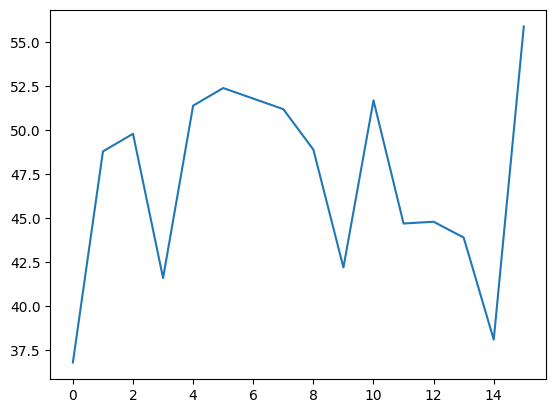

In [189]:
plt.plot(range(numSteps), df[(df.rnd==0)&(df.period==0)].price)
plt.axhline(df_period[(df_period.rnd==0)&(df_period.period==0)].p)

In [180]:
tokenValues = generateTokens()
buyerValues = tokenValues[0:numBuyers]
sellerCosts = tokenValues[numBuyers:(numBuyers+numSellers)]

def demandSupplySchedules(buyerValues, sellerCosts, granularity = 200, minprice = 0, maxprice = 100):
    prices = np.linspace(minprice, maxprice, granularity)
    demand = np.zeros((granularity), dtype='int')
    supply = np.zeros((granularity), dtype='int')
    for i, price in enumerate(prices):
        demand[i] = np.round(np.sum(price < buyerValues))
        supply[i] = np.round(np.sum(price > sellerCosts))
    return demand, supply, prices

def equilibrium(demand,supply,prices):
    clearingPrices, clearingQuantity = [], np.nan
    for i, price in enumerate(prices):
        if demand[i] == supply[i]:
            clearingPrices.append(price)
            clearingQuantity = demand[i]
            
    if len(clearingPrices) == 0: # if no clearing price
        minDiffIdx = np.argmin(np.abs(demand-supply))
        clearingPrices = prices[minDiffIdx] 
        clearingQuantity = demand[minDiffIdx]

    clearingPrice = np.nanmean(clearingPrices)
    clearingPrice = np.round(clearingPrice,1)
    return np.round(clearingPrice,1), clearingQuantity 

def reservationPrices(demand, supply,prices):
    demandChangeIdx = np.where(demand[:-1] != demand[1:], 1, 0)
    demandChangeIdx = np.pad(demandChangeIdx, (0,1))
    buyerReservationPrices = prices[demandChangeIdx==1] # price at which one more token would get sold

    supplyChangeIdx = np.where(supply[:-1] != supply[1:], 1, 0)
    supplyChangeIdx = np.pad(supplyChangeIdx, (0,1))
    sellerReservationPrices = prices[supplyChangeIdx==1]
    return buyerReservationPrices, sellerReservationPrices

def surplus(buyerValues, sellerCosts, clearingPrice, clearingQuantity):
    buyerSurplus = np.round(np.sum(buyerValues - clearingPrice, where = buyerValues - clearingPrice > 0),1)
    sellerSurplus = np.round(np.sum(clearingPrice - sellerCosts, where = clearingPrice - sellerCosts > 0),1)
    totalSurplus = np.round(buyerSurplus + sellerSurplus)
    buyerSurplusFrac = np.round(buyerSurplus/totalSurplus,1)
    sellerSurplusFrac = np.round(sellerSurplus/totalSurplus,1)
    return buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac

def plannerSolution(tokenValues):
    buyerValues = tokenValues[0:numBuyers]
    sellerCosts = tokenValues[numBuyers:(numBuyers+numSellers)]
    demand, supply, prices = demandSupplySchedules(buyerValues,sellerCosts)
    clearingPrice, clearingQuantity = equilibrium(demand,supply,prices)
    buyerReservationPrices, sellerReservationPrices = reservationPrices(demand, supply,prices)
    buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac = surplus(buyerValues,sellerCosts,clearingPrice, clearingQuantity)
    return [clearingPrice, clearingQuantity, buyerSurplus, sellerSurplus, totalSurplus, buyerSurplusFrac, sellerSurplusFrac]